# Training while monitoring observables

As seen in the first tutorial that went through reconstructing the wavefunction describing the TFIM with 10 sites at its critical point, the user can evaluate the training in real time with the *MetricEvaluator* and custom functions. What is most likely more impactful in many cases is to calculate an observable, like the energy, during the training process. This is slightly more computationally involved than using the *MetricEvaluator* to evaluate functions because observables require that samples be drawn from the RBM. 

Luckily, qucumber also has a module very similar to the *MetricEvaluator*, but for observables. This is called the *ObservableEvaluator*. The following implements the *ObservableEvaluator* to calculate the energy during the training on the TFIM data in the first tutorial. We will use the same hyperparameters as before.

It is assumed that the user has worked through tutorial 3 beforehand. Recall that *quantum_ising_chain.py* contains the *TFIMChainEnergy* class that inherits from the *Observable* module. The exact ground-state energy is -1.2381.

In [1]:
import os.path

import numpy as np
import matplotlib.pyplot as plt

from qucumber.nn_states import PositiveWavefunction
from qucumber.callbacks import ObservableEvaluator

import qucumber.utils.data as data

from quantum_ising_chain import TFIMChainEnergy

In [2]:
train_data = data.load_data(
    os.path.join("..", "Tutorial1_TrainPosRealWavefunction", "tfim1d_data.txt")
)[0]

nv = train_data.shape[-1]
nh = nv

nn_state = PositiveWavefunction(num_visible=nv, num_hidden=nh)

epochs = 1000
pbs = 100  # pos_batch_size
nbs = 200  # neg_batch_size
lr = 0.01
k = 10

log_every = 100

h = 1
num_samples = 10000
burn_in = 100
steps = 100

tfim_energy = TFIMChainEnergy(h)

Now, the *ObservableEvaluator* can be called. The *ObservableEvaluator* requires the following arguments.

1. **log_every**: the frequency of the training evaluators being calculated is controlled by the *log_every* argument (e.g. *log_every* = 200 means that the *MetricEvaluator* will update the user every 200 epochs)
2. A list of *Observable* objects you would like to reference to evaluate the training (arguments required for generating samples to calculate the observables are keyword arguments placed after the list)

The following additional arguments are needed to calculate the statistics on the generated samples during training (these are the arguments of the *statistics* function in the *Observable* module, minus the *nn_state* argument; this gets passed in as an argument to *fit*). 

- **num_samples**: the number of samples to generate internally
- **num_chains**: the number of Markov chains to run in parallel (default = 0)
- **burn_in**: the number of Gibbs steps to perform before recording any samples (default = 1000)
- **steps**: the number of Gibbs steps to perform between each sample (default = 1)

The training evaluators can be printed out via the *verbose=True* statement.

In [3]:
callbacks = [
    ObservableEvaluator(
        log_every,
        [tfim_energy],
        verbose=True,
        num_samples=num_samples,
        burn_in=burn_in,
        steps=steps,
    )
]

nn_state.fit(
    train_data,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    callbacks=callbacks,
)

Epoch: 100
  TFIMChainEnergy:
    mean: -1.201278	variance: 0.021548	std_error: 0.001468
Epoch: 200
  TFIMChainEnergy:
    mean: -1.219468	variance: 0.011539	std_error: 0.001074
Epoch: 300
  TFIMChainEnergy:
    mean: -1.224349	variance: 0.008127	std_error: 0.000901
Epoch: 400
  TFIMChainEnergy:
    mean: -1.230518	variance: 0.005740	std_error: 0.000758
Epoch: 500
  TFIMChainEnergy:
    mean: -1.231123	variance: 0.004706	std_error: 0.000686
Epoch: 600
  TFIMChainEnergy:
    mean: -1.233050	variance: 0.003661	std_error: 0.000605
Epoch: 700
  TFIMChainEnergy:
    mean: -1.232585	variance: 0.003376	std_error: 0.000581
Epoch: 800
  TFIMChainEnergy:
    mean: -1.233423	variance: 0.002802	std_error: 0.000529
Epoch: 900
  TFIMChainEnergy:
    mean: -1.234941	variance: 0.002430	std_error: 0.000493
Epoch: 1000
  TFIMChainEnergy:
    mean: -1.236174	variance: 0.001987	std_error: 0.000446


The *callbacks* list returns a list of dictionaries. The mean, standard error and the variance at each epoch can be accessed as follows.

In [4]:
energies = callbacks[0].TFIMChainEnergy.mean
errors = callbacks[0].TFIMChainEnergy.std_error
variance = callbacks[0].TFIMChainEnergy.variance
# Please note that the name of the observable class that the
# user makes must be what comes after callbacks[0].

A plot of the energy as a function of the training cycle is presented below.

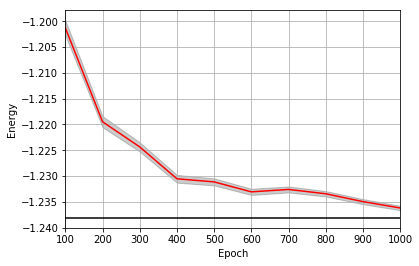

In [5]:
epoch = np.arange(log_every, epochs + 1, log_every)

E0 = -1.2381

ax = plt.axes()
ax.plot(epoch, energies, color="red")
ax.set_xlim(log_every, epochs)
ax.axhline(E0, color="black")
ax.fill_between(epoch, energies - errors, energies + errors, alpha=0.2, color="black")
ax.set_xlabel("Epoch")
ax.set_ylabel("Energy")
ax.grid()